In [119]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from google.colab import drive
import networkx as nx
import copy
import random


device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)
print('device :',device)
print('torch.version :',torch.__version__)

device : cpu
torch.version : 1.7.0+cu101


In [120]:
drive.mount('/content/drive')
folder_dir = '/content/drive/My Drive/cora'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [121]:
class Cora(object):
    
    def __init__(self, base_dir):
        data = np.genfromtxt(base_dir + '/cora/cora.content', dtype=np.str)
        

        self.category_list = list(set(data[:, -1]))
        self.cat2lab = {category:label for label, category in enumerate(self.category_list)}
        self.lab2cat = {label:category for label, category in enumerate(self.category_list)}
        
        self.paper_list = np.array(data[:, 0], dtype=np.int)
        self.paper2node = {paper_id:node_id for node_id, paper_id in enumerate(self.paper_list)}
        self.node2paper = {node_id:paper_id for node_id, paper_id in enumerate(self.paper_list)}


        self.node_feature = np.array(data[:, 1:-1], dtype=int)
        self.node_label = [self.cat2lab[category] for category in data[:, -1]]
        
        self.edge = np.genfromtxt(base_dir + '/cora/cora.cites',   dtype=np.int)
        
        self.node_connection_list = [[] for _ in range(data.shape[0])]

        for i, (cited, citing) in enumerate(self.edge):
            cited_node = self.paper2node[cited]
            citing_node = self.paper2node[citing]
            self.node_connection_list[cited_node].append(citing_node)
            

    def get_data(self):
        node_feature = np.copy(self.node_feature)
        node_label = np.copy(self.node_label)
        node_connection_list = [node_list for node_list in self.node_connection_list]
        return node_feature, node_label, node_connection_list



def to_undirected_connection_list(src):
    tar = copy.deepcopy(src)
    for i, node_list in enumerate(src):
        for node in node_list:
            tar[node].append(i)
        tar[i].append(i) # self loof
       
    for i in range(len(src)):
        tar[i] = sorted(list(set(tar[i])))
        
    return tar

cora = Cora(base_dir='/content/drive/My Drive')
node_feature, node_label, node_connection_list = cora.get_data()
undirected_connection_list = to_undirected_connection_list(node_connection_list)

In [122]:
def choice(neighbor_list, num_samples):
    neighbor_list = copy.deepcopy(neighbor_list)
    if len(neighbor_list) < num_samples:
        return neighbor_list
        
    choiced = []
    for _ in range(num_samples):
        if len(neighbor_list) == 0:
            break
        v = random.choice(neighbor_list)
        choiced.append(v)
        neighbor_list.remove(v)
    return choiced


def sample(target_nodes, edges, num_samples):

    layer_nodes = [copy.deepcopy(target_nodes)]
    next_mapping_list = []

    for k, n_k in enumerate(num_samples):    

        src_nodes = layer_nodes[-1]
        
        tar_nodes = copy.deepcopy(src_nodes)
        
        for u in src_nodes:
            tar_nodes += choice(edges[u], n_k)

        tar_nodes = list(set(tar_nodes))

        src2tar_map = [[] for _ in src_nodes]

        for src_idx, u in enumerate(src_nodes):
            for tar_idx, v in enumerate(tar_nodes):
                if u in edges[v]:
                    src2tar_map[src_idx].append(tar_idx)
        
        layer_nodes.append(tar_nodes)
        next_mapping_list.append(src2tar_map)


    first_layer_nodes = layer_nodes.pop()
    
    layer_nodes.reverse()
    next_mapping_list.reverse()
        
    return first_layer_nodes, layer_nodes, next_mapping_list


In [123]:

def generate_pos_neg_pairs(edges, num_walks, walk_length, window_size, Q):



    num_nodes = len(edges)

    pos_pair = []
    
    for _ in range(num_walks):

        walk = np.random.randint(0, num_nodes, size=(1)).tolist()
        for t in range(walk_length):
            curr_node = walk[-1]
            curr_node_neigbhors = copy.deepcopy(edges[curr_node])

            if curr_node in curr_node_neigbhors:
                curr_node_neigbhors.remove(curr_node)


            selected_next_node = np.random.choice(curr_node_neigbhors, 1)[0]
            walk.append(selected_next_node)



        for t in range(walk_length):
            for k in range(t - window_size, t + window_size + 1):
                if k >= 0 and k < walk_length:
                    if k != t:
                        pos_pair.append([walk[t], walk[k]])

    
    neg_pair = np.random.randint(0, num_nodes, size=(Q * len(pos_pair), 2)).tolist()


    pair = pos_pair + neg_pair

    label = [1 for _ in pos_pair] + [0 for _ in neg_pair]


    return pair, label


pair, label = generate_pos_neg_pairs(undirected_connection_list, 4, 20, 2, 8)



In [124]:
class GraphSAGE(nn.Module):

    def __init__(self):
        super().__init__()

        self.net = nn.ModuleList([
            nn.Sequential(nn.Linear(in_features=2866, out_features=16, bias=False),
                          nn.ReLU(),
                          nn.BatchNorm1d(16),
                          nn.Dropout(0.5)),
            nn.Linear(in_features=32, out_features=2, bias=False)
        ])


    def forward(self, feature, B, ptrs):
        x = feature
        for k in range(len(ptrs)):

            next_x = []

            for i in range(len(B[k])):
                h_u = x[i]
                h_nu = self.aggregate(x[ptrs[k][i], :])
                next_x.append(torch.cat([h_u, h_nu], dim=0))
    
            x = torch.stack(next_x, dim=0)
            x = self.net[k](x)
            if k < len(ptrs) - 1:
                x = x / (x.norm(dim=1, keepdim=True) + 1e-6)

        return x


    def aggregate(self, x):
        return x.mean(dim=0)


X = torch.Tensor(node_feature.astype(np.float))
model = GraphSAGE()
solver = optim.Adam(model.parameters(),  lr=1e-3)

In [125]:
LOSS = 0.0
for epoch in range(100):


    pair, label = generate_pos_neg_pairs(undirected_connection_list, 4, 30, 2, 7)
    
    order = [i for i in range(len(pair))]
    random.shuffle(order)
    for i in order:


        solver.zero_grad()


        first_layer_nodes, layer_nodes, next_mapping_list = sample(pair[i], undirected_connection_list, [25, 25])
        pred = model(X[first_layer_nodes], layer_nodes, next_mapping_list)
        
        inner_product = (pred[0] * pred[1]).sum()

        loss = 0.0

        if label[i] == 1:
            loss = torch.log(1.0 + torch.exp(-inner_product))
        else :
            loss = torch.log(1.0 + torch.exp(inner_product))



        loss.backward()
        solver.step()
        LOSS += loss.item()
    LOSS /= len(pair)
    if epoch % 10 == 9:
        print(LOSS)



0.22812751932385888
0.15733497990366221
0.1473321903391196
0.16316056587817102
0.1548859539831284
0.14233345193654212
0.1648185493042448
0.1360895664575642
0.13808778175937075
0.15960880040796954


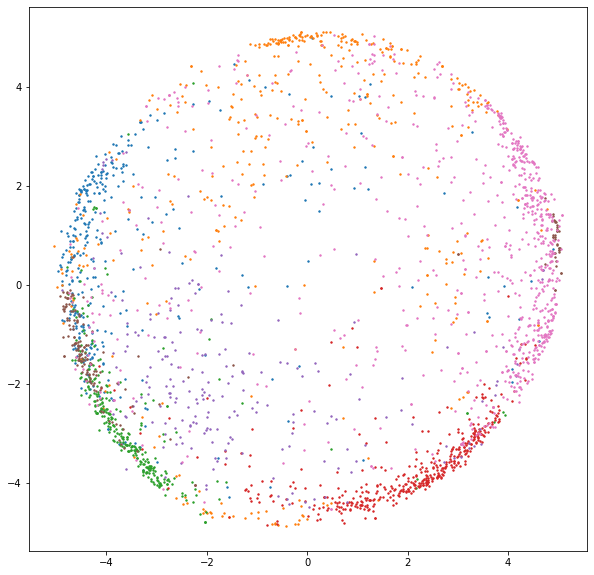

In [126]:
model.eval()
labels = np.array(cora.node_label)
representation = []
for i in range(len(labels)):
    first_layer_nodes, layer_nodes, next_mapping_list = sample([i], undirected_connection_list, [10, 25])
    z = model(X[first_layer_nodes], layer_nodes, next_mapping_list)
    representation.append(z)
    
representation = torch.cat(representation, dim=0).detach().numpy()

plt.figure(figsize=(10, 10))

for i in range(7):
    node_list = labels == i
    plt.scatter(representation[node_list, 0], representation[node_list, 1], s=2)

plt.show()
